In [1]:
import os
import sys
sys.path.append("..")

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

from models import get_model, model_config
from data import data_config
from data import get_data
from main import get_device



class ProtendArgs:
    model = "FullyConnectedNetwork"
    #model = "resnet50"
    #pretrained = True
    #model = "VGG_like"
    dataset = "TwilightDuo"
    model_config = [2048, 512]
    #model_config = [32, 'M', 64, 'M', 128, 'M', 256, 'M', 512, 'M', 1024, 'M', 1024, 'M', 1024]
    #model_config = None
    
    train_size = 100
    train_bias = 1
    #repr_module = "avgpool"
    #repr_module = "features.maxpool14"
    repr_module = "features.relu2"
    
    
    
def load_model(args, fname=None):
    if fname is not None:
        base_folder = "/scratch/ym2380/saved_models"
        fname = f"{fname}.pth"
        fpath = os.path.join(base_folder, args.model, args.dataset, fname)
    
    model = get_model(args)
    
    if fname is not None:
        model.load_state_dict(torch.load(fpath))
    
    #for param in model.parameters():
    #    param.requires_grad = False
    #for param in model.classifier.parameters():
    #    param.requires_grad = True
    
    return model

In [2]:
args = ProtendArgs()
device = get_device()

data = get_data(args, 'train')
loader = DataLoader(data, shuffle=True, batch_size=1)

network = load_model(args, "10180408_9").to(device)
network.eval()

activations = []
def hook(module, input, output):
    activations.append(output)
    
exec(f"handle = network.{args.repr_module}.register_forward_hook(hook)")

In [5]:
for X, _ in loader:
    with torch.no_grad():
        if args.model == "FullyConnectedNetwork":
            X = X.view(X.size(0), -1)
        network(X)

In [6]:
print(len(activations))
print(activations[0].shape)

100
torch.Size([1, 512])


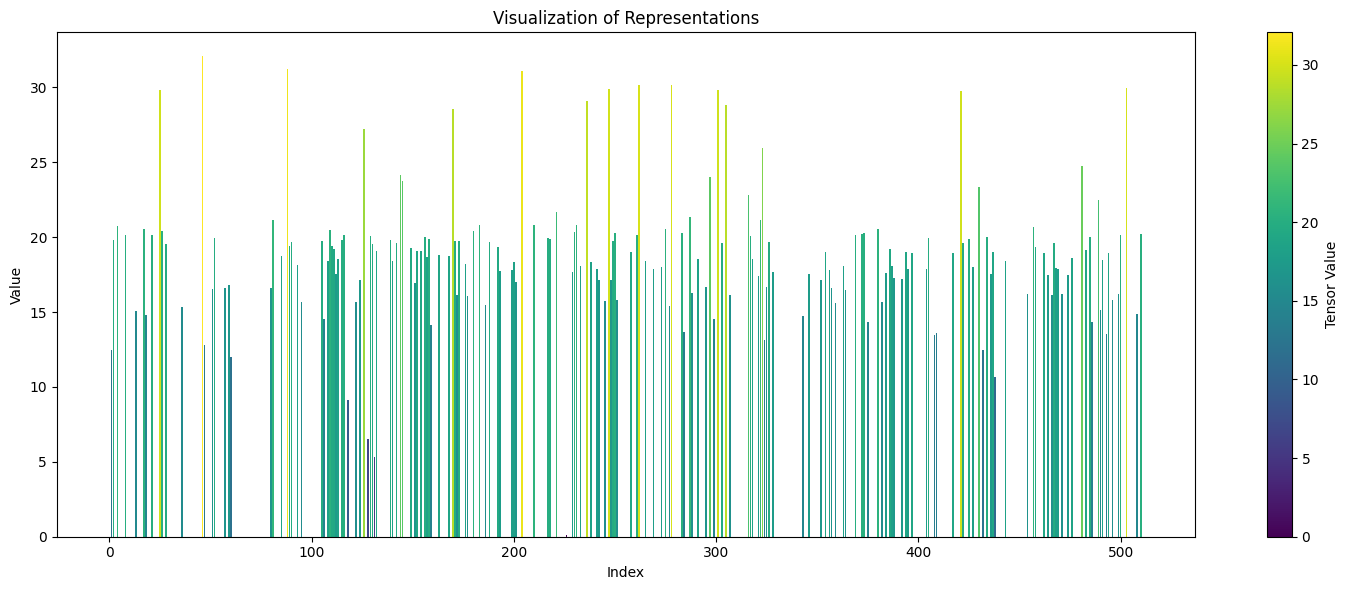

n_zeros: 319 / 512


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

tensor = activations[1][0].squeeze()

norm = plt.Normalize(tensor.min(), tensor.max())
colors = plt.cm.viridis(norm(tensor.numpy()))

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(range(tensor.shape[0]), tensor, color=colors)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical', label='Tensor Value')

ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Visualization of Representations')

plt.tight_layout()
plt.show()

print(f"n_zeros: {tensor.eq(0).sum().item()} / {tensor.shape[0]}")